In [ ]:
import torch
import torch.nn as nn
import torch.optim as optims
import torch.nn.functional as F
import torchvision.models as model
import torchvision.transforms as T
import imageio
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
dtype = torch.cuda.FloatTensor
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

此部分注意它會訓練失敗的原因，不僅僅是在於style_weight或是layer的選取，其中根據paper其實可以看到他在調整coontent與style loss的部分也是很重要的，特別是在結果的部分有看到範圍是在1e-4~1e-1，並不是直接的一比一的關係。

In [ ]:
mean = np.array([0.485, 0.456, 0.406], dtype = np.float32)
std = np.array([0.229, 0.224, 0.225], dtype = np.float32)

In [ ]:
def preprocessing(img,size = 512):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean = mean.tolist(),std = std.tolist()),
        T.Lambda(lambda x: x[None])
    ])
    return transform(img)
  
def deprocessing(img):
    transform = T.Compose([
        T.Lambda(lambda x : x[0]),
        T.Normalize(mean = [0.0,0.0,0.0],std = [1/p for p in std]),
        T.Normalize(mean = [-m for m in mean], std = [1.0,1.,1.]),
        T.Lambda(rescale),
        T.ToPILImage()
    ])
    return transform(img)
  
def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

In [ ]:
def Content_loss(content_weight, content_target, content):
    return content_weight * torch.sum((content_target - content)**2)
  
def Gram_matrix(images, normalize = True):
    image_number, channel, width, height = images.size()
    images = images.view(image_number,channel,width * height)
    gram_matrix = torch.empty((image_number, channel, channel))
    for i in range(image_number):
        gram_matrix[i] = torch.matmul(images[i],images[i].t())
    if normalize:
        gram_matrix /= (1.0 * image_number * channel * width *height)
    return gram_matrix
  
def Style_loss(feats,style_layers, style_weights, style_targets):
    loss = torch.zeros(1)
    for i, w in enumerate(style_weights):
        loss += w * torch.sum((Gram_matrix(feats[style_layers[i]]) - style_targets[i])**2)
    return loss.type(dtype)
def Tv_loss(image, tv_weight):
    image_number, channel, height, width = image.size()
    loss =  tv_weight * (torch.sum((image[:,:,1:height,:] - image[:,:,0:height - 1,:])**2) + torch.sum((image[:,:,:,1:width] - image[:,:,:,:width - 1])**2))
    return loss

In [ ]:
def extract_feature(image, cnn):
    features = []
    current_feature = image
    for i, module in enumerate(cnn._modules.values()):
        next_feature = module(current_feature)
        features.append(next_feature)
        current_feature = next_feature
    return features
    

In [ ]:
def style_transfer(content_name,style_name,content_size, style_size, content_layer, style_layers, content_weight, style_weights, tv_weight):
    
    pre_net = model.squeezenet1_1(pretrained = True).features
    pre_net.type(dtype)
    content_image = preprocessing(Image.open(content_name),content_size)
   
    content_target = extract_feature(content_image.type(dtype),pre_net)[content_layer]
    
    style_image = preprocessing(Image.open(style_name),style_size)
    style_feats = extract_feature(style_image.type(dtype), pre_net)
    
    style_targets = []
    
    for idx in style_layers:
        style_targets.append(Gram_matrix(style_feats[idx]))
    
    img = content_image.clone().type(dtype)
    
    initial_lr = 3.0
    decayed_lr = 0.1
    decay_lr_at = 180
    
    
    img.requires_grad_()
    optim = optims.Adam([img],lr = initial_lr)
    for i in range(200):
      
        if i < 190:
            img.data.clamp_(-1.5, 1.5)
      
        optim.zero_grad()
        feats = extract_feature(img, pre_net)
        c_loss = Content_loss(content_weight,content_target, feats[content_layer])
        s_loss = Style_loss(feats,style_layers,style_weights,style_targets)
        t_loss = Tv_loss(img,tv_weight)
        loss = c_loss + s_loss + t_loss
        if i %100 == 0:
            print(loss)
            
        if i == decay_lr_at:
            optim = optims.Adam([img],lr = decayed_lr)
        loss.backward(retain_graph=True )
        optim.step()
    img2 = deprocessing(img.detach().cpu())
    
    return img2

In [ ]:
config = {
    'content_name':'tubingen.jpg',
    'style_name':'the_scream.jpg',
    'content_size':192,
    'style_size':192,
    'content_layer': 3,
    'style_layers': (1,4,6,7),
    'content_weight': 6e-2,
    'style_weights': [20000, 800, 15, 3],
    'tv_weight':2e-2
}

In [ ]:
img = style_transfer(**config)

Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /root/.cache/torch/checkpoints/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:00<00:00, 7695427.61it/s]


tensor([70340.7969], device='cuda:0', grad_fn=<AddBackward0>)
tensor([42669.7578], device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
img.save('new_image.png')

(192, 256, 3)


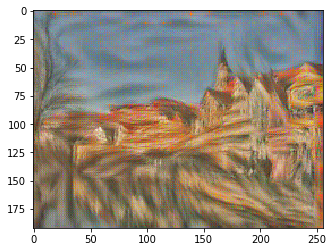

In [ ]:
img2 = imageio.imread('new_image.png')
print(img2.shape)
plt.imshow(img2)